## Librerias y primer vistazo a los datos


In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm.auto import tqdm
from IPython.display import display
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn, sentiwordnet as swn
from functools import lru_cache
from dataclasses import dataclass, field
import contractions

#Descargas NLTK necesarias
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon')
except Exception as e:
    print("Aviso NLTK:", e)

#Inicialización spaCy 
try:
    nlp
except NameError:
    try:
        nlp = spacy.load('en_core_web_sm', disable=['ner'])
    except Exception:
        try:
            nlp = spacy.load('es_core_news_sm', disable=['ner'])
        except Exception as e:
            print("Falta un modelo de spaCy. Instala uno:")
            print("python -m spacy download en_core_web_sm o es_core_news_sm")
            raise

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)
print("Entorno listo: imports y spaCy inicializados")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wail-\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Entorno listo: imports y spaCy inicializados


### Vistazo general al dataframe


In [3]:
data = pd.read_csv('dataset/df_200k.csv')
data.head()


,target,id,date,flag,user,text
0,4,1793657674,Thu May 14 03:31:43 PDT 2009,NO_QUERY,marita_holm,Looks like the sun finally located Trondheim ;...
1,0,1971008586,Sat May 30 05:56:45 PDT 2009,NO_QUERY,addicthim,A long weekend begins. The sun is shining and ...
2,4,1881031249,Fri May 22 03:21:42 PDT 2009,NO_QUERY,susietech,to the beach we go! hope it stays nice...
3,0,1795951084,Thu May 14 08:38:29 PDT 2009,NO_QUERY,KatieBlockley,@JBFutureboy I missed it busted need to do a ...
4,0,1978767005,Sun May 31 00:23:54 PDT 2009,NO_QUERY,Camila_love,Why I can't change my background image??


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   id      200000 non-null  int64 
 2   date    200000 non-null  object
 3   flag    200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [5]:
data.describe()


,target,id
count,200000.000000,2.000000e+05
mean,2.000000,1.999194e+09
std,2.000005,1.931002e+08
min,0.000000,1.467812e+09
25%,0.000000,1.956966e+09
50%,2.000000,2.002192e+09
75%,4.000000,2.177052e+09
max,4.000000,2.329205e+09


In [6]:
data.isnull().sum()


target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [7]:
data_clean = data[["text"]]
data_clean.head()


,text
0,Looks like the sun finally located Trondheim ;...
1,A long weekend begins. The sun is shining and ...
2,to the beach we go! hope it stays nice...
3,@JBFutureboy I missed it busted need to do a ...
4,Why I can't change my background image??


## 1. Análisis exploratorio y preprocesamiento


### Análisis estadístico del corpus


In [8]:
#Tokenización y limpieza básica 
#para el análisis inicial
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text) #quitamos URLs
    text = re.sub(r'@\w+', ' ', text) #quitamos menciones
    text = re.sub(r'#', ' ', text) #quitamos # pero mantenemos la palabra por si es relevante

    #conservamos letras y números 
    #quitamos acentos 
    text = re.sub(r'[^0-9a-záéíóúüñ\s]', ' ', text, flags=re.IGNORECASE)
    tokens = re.findall(r'\w+', text, flags=re.UNICODE)
    return tokens


In [9]:
#Construimos la distribución de frecuencias de tokens
freq = Counter()
total_tokens = 0
for doc in data_clean['text'].astype(str):
    toks = clean_and_tokenize(doc)
    freq.update(toks)
    total_tokens += len(toks)

vocab = len(freq)
print(f"Tokens totales: {total_tokens:,}")
print(f"Vocabulario (tipos): {vocab:,}")


Tokens totales: 2,627,748
Vocabulario (tipos): 80,814


In [10]:
#DataFrame-like structures para análisis
#Construimos la distribución de frecuencias de tokens
words, counts = zip(*freq.most_common())
ranks = np.arange(1, len(counts) + 1)
counts_arr = np.array(counts)


### Grafico Ley de Zipf


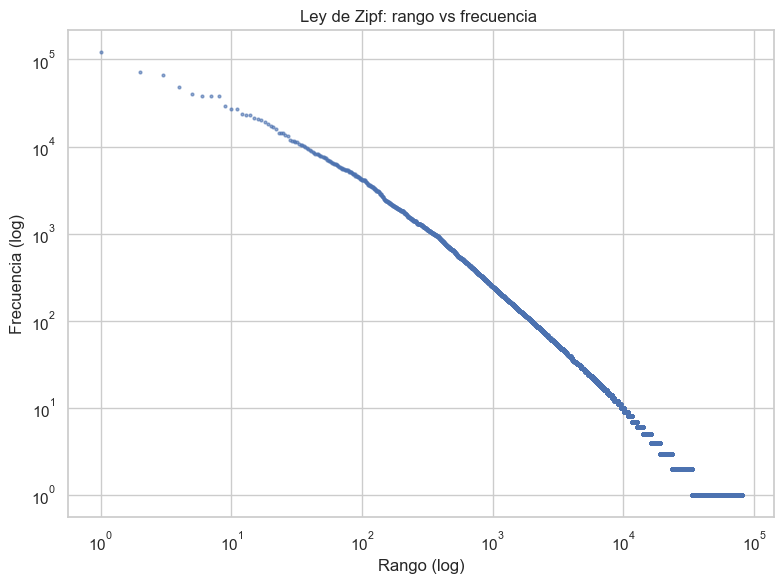

In [11]:
#Ley de Zipf: gráfico rango vs frecuencia en escala logarítmica
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango (log)') #la posición de cada palabra según su frecuencia 
plt.ylabel('Frecuencia (log)') #cuántas veces aparece cada palabra en el corpus
plt.title('Ley de Zipf: rango vs frecuencia ')
plt.tight_layout()
plt.show()


El corpus sigue la Ley de Zipf ya que la frecuencia de las palabras decae de forma inversa proporcional a su rango. 

Ajuste log-log (primeros 2000): slope = -1.1794, intercept = 13.6558
Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)


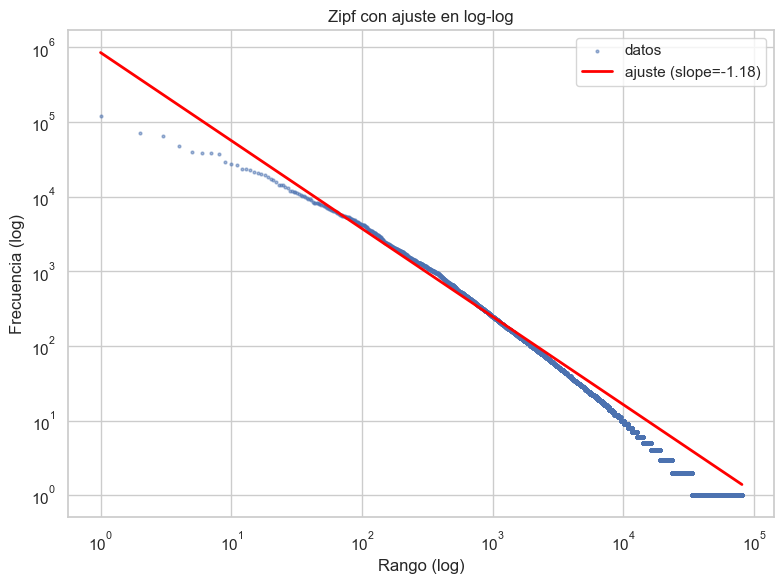

In [12]:
#Ajuste lineal en log-log para los primeros K ranks 
K = min(2000, len(counts_arr)) #seleccionamos las 2000 palabras más frecuentes porque son suficientes y añadiendo todas, al haber muchas palabras poco frecuentes, el ajuste empeora
log_r = np.log(ranks[:K])
log_f = np.log(counts_arr[:K])
slope, intercept = np.polyfit(log_r, log_f, 1)
print(f"Ajuste log-log (primeros {K}): slope = {slope:.4f}, intercept = {intercept:.4f}")
print("Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)")

#Dibujamos la línea ajustada sobre el scatter 
pred_logf = intercept + slope * np.log(ranks[:])
pred_f = np.exp(pred_logf)
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.5, label='datos')
plt.plot(ranks[:], pred_f, color='red', lw=2, label=f'ajuste (slope={slope:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Zipf con ajuste en log-log')
plt.legend()
plt.tight_layout()
plt.show()


Decaye un poco más rápido que la Ley de Zipf clásica, ya que las palabras más frecuentes dominan ligeramente más que en un corpus típico. Común en datos de redes sociales o reseñas ya que las palabras como "bad", "good" o "hate" son más frecuentes.

### Grafico distribuciones


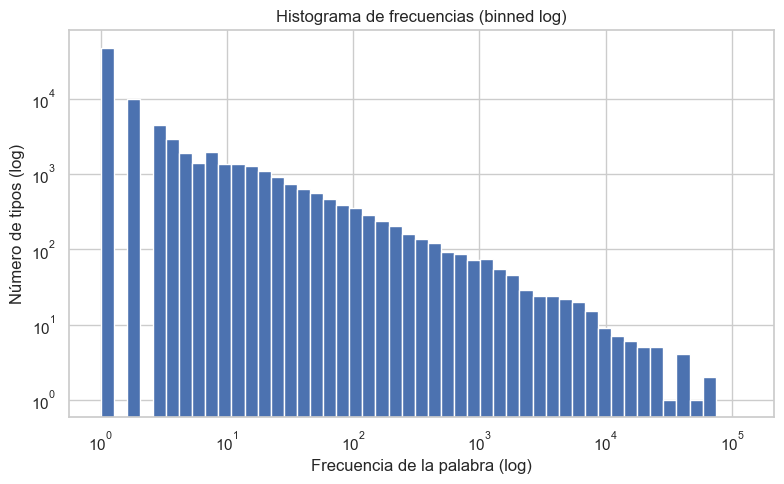

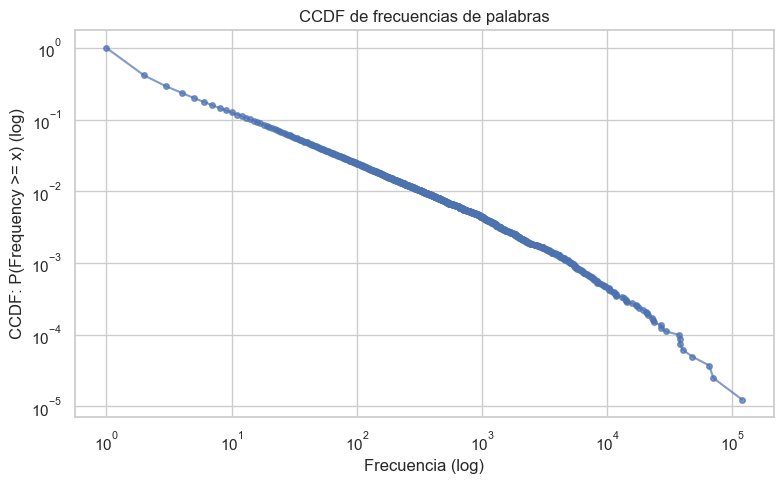

In [13]:
#Distribución de frecuencias: histograma y CCDF
#Histograma con ejes logarítmicos
#Dividimos la frecuencia de las palabras en bins logarítmicos y cuenta cuántas palabras caen en cada bin
plt.figure(figsize=(8,5))
plt.hist(counts_arr, bins=np.logspace(np.log10(1), np.log10(counts_arr.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frecuencia de la palabra (log)')
plt.ylabel('Número de tipos (log)')
plt.title('Histograma de frecuencias (binned log)') #nos permite ver claramente la gran diferencia entre palabras muy frecuentes y raras
plt.tight_layout()
plt.show()

#CCDF: muestra la proporción de palabras que tienen frecuencia mayor o igual a x
sorted_counts = np.sort(counts_arr)
unique_vals, counts_of_vals = np.unique(sorted_counts, return_counts=True)
ccdf_vals = np.cumsum(counts_of_vals[::-1])[::-1] / vocab  #proporción de tipos >= val
plt.figure(figsize=(8,5))
plt.loglog(unique_vals, ccdf_vals, marker='o', ms=4, alpha=0.7)
plt.xlabel('Frecuencia (log)')
plt.ylabel('CCDF: P(Frequency >= x) (log)')
plt.title('CCDF de frecuencias de palabras')
plt.tight_layout()
plt.show()


## Pipeline de limpieza específico para tweets


In [14]:
#Stopwords en inglés
stop_words = set(stopwords.words('english'))

#Limpieza de URLs y menciones
URL_PATTERN = r"http\S+|www\.\S+"
MENTION_PATTERN = r"@\w+"

#Sustituimos cualquier cosa no alfabética por espacio (dejamos espacios)
NON_ALPHA_PATTERN = r"[^a-z\s]"
EMOJI_PATTERN = r"[\U00010000-\U0010ffff]"  #rango Unicode emojis y pictos

def preprocess_review(text: str, nlp, stop_words) -> list:
    
    #1.lower + contracciones
    text = text if isinstance(text, str) else str(text)
    text = text.lower()
    text = contractions.fix(text)  #por ejemplo, "can't" pasaría a ser "cannot"

    #2.ruido típico de tweets
    text = re.sub(URL_PATTERN, " ", text)
    text = re.sub(MENTION_PATTERN, " ", text)
    #Números y emojis son mapeados a tags para no perder la señal semántica
    text = re.sub(r"\d+", " <NUM> ", text)
    text = re.sub(EMOJI_PATTERN, " <EMOJI> ", text)
    #El resto de signos no alfabéticos fuera también
    text = re.sub(NON_ALPHA_PATTERN, " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    #3.Lematización spaCy
    #spaCy tokeniza y da lemma por token; aquí ignoramos signos ya filtrados
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc]

    #4.Filtrado final: stopwords + longitud mínima
    clean_lemmas = [w for w in lemmas if w not in stop_words and len(w) > 2]

    return clean_lemmas


In [15]:
#Pasamos de data_clean a df para que sea más cómodo
df = data_clean.copy()

#Aplica el pipeline completo 
df['lemmas'] = df['text'].astype(str).apply(lambda s: preprocess_review(s, nlp, stop_words))

#Texto limpio “join” 
df['clean_text'] = df['lemmas'].apply(lambda xs: " ".join(xs))

print(f"Procesadas {len(df)} tweets. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'")
df.head(3)


Procesadas 200000 tweets. Columnas añadidas: 'lemmas', 'tokens', 'clean_text'


,text,lemmas,clean_text
0,Looks like the sun finally located Trondheim ;...,"[look, like, sun, finally, locate, trondheim, ...",look like sun finally locate trondheim hope su...
1,A long weekend begins. The sun is shining and ...,"[long, weekend, begin, sun, shine, happy, exam...",long weekend begin sun shine happy exam soon
2,to the beach we go! hope it stays nice...,"[beach, hope, stay, nice]",beach hope stay nice


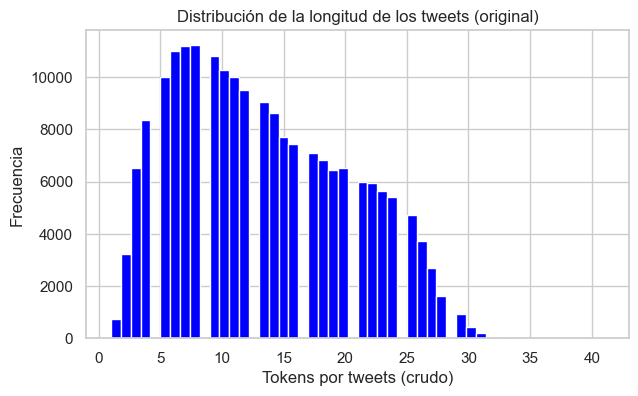

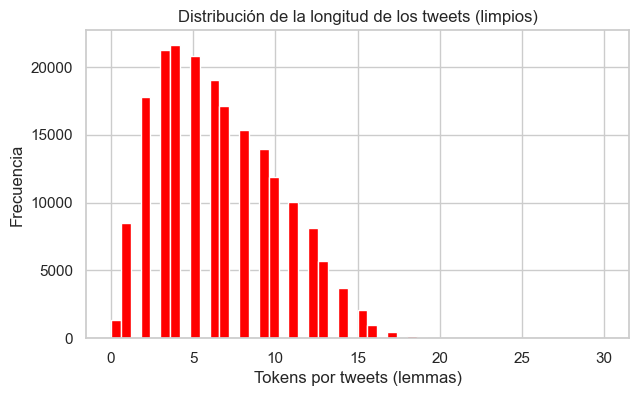

 Media longitud cruda: 13.18 | Media longitud limpia: 6.47


In [16]:
#Longitud cruda por tweets (por número de palabras)
len_raw = df['text'].astype(str).apply(lambda s: len(s.split()))

#Longitud tras limpieza (por número de lemas por tweets)
len_clean = df['lemmas'].apply(len)

#Histograma antes y después de limpieza
plt.figure(figsize=(7,4))
plt.hist(len_raw, bins=50, color='blue')
plt.title("Distribución de la longitud de los tweets (original)")
plt.xlabel("Tokens por tweets (crudo)")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(len_clean, bins=50, color='red')
plt.title("Distribución de la longitud de los tweets (limpios)")
plt.xlabel("Tokens por tweets (lemmas)")
plt.ylabel("Frecuencia")
plt.show()

print(f" Media longitud cruda: {len_raw.mean():.2f} | Media longitud limpia: {len_clean.mean():.2f}")


La limpieza reduce casi a la mitad la cantidad de palabras, eliminando stopwords, URLs, menciones, números irrelevantes y símbolos. Quedando tokens mucho más representativos del contenido semántico para entrenar el clasificador de sentimientos.

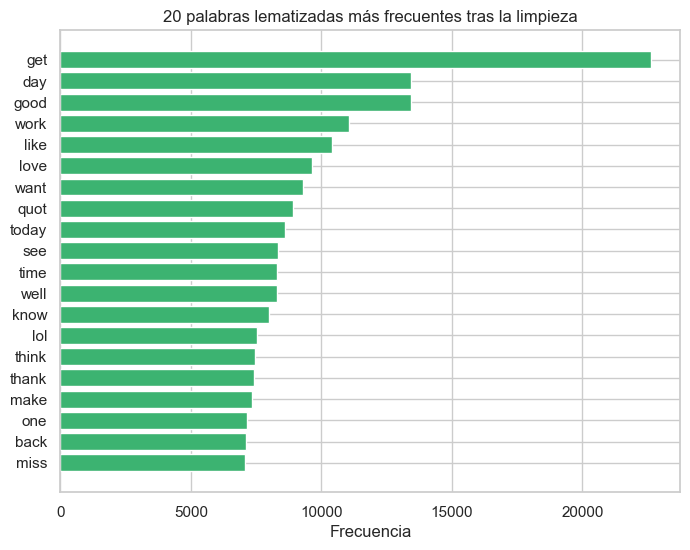

In [17]:
#Aplanamos la lista de lemas
flat_lemmas = [w for toks in df['lemmas'] for w in toks]
top20 = Counter(flat_lemmas).most_common(20)

#Mostramos el top-20
words, freqs = zip(*top20)
plt.figure(figsize=(8,6))
plt.barh(words, freqs, color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("20 palabras lematizadas más frecuentes tras la limpieza")
plt.xlabel("Frecuencia")
plt.show()


## Identificación de patrones sintácticos relevantes


C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\43231440.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')


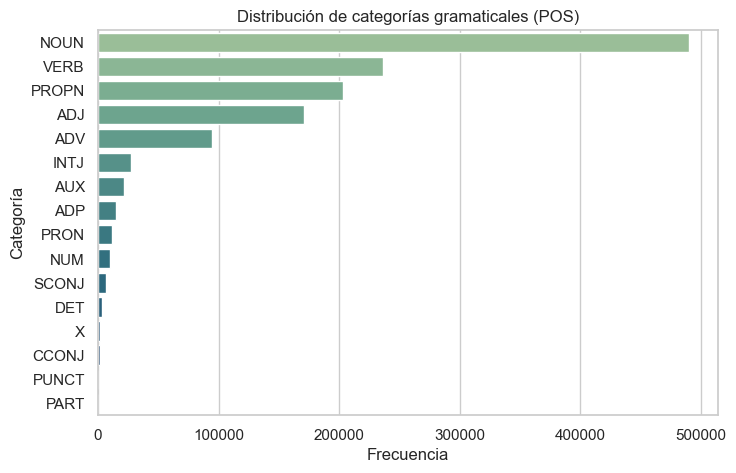

C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\43231440.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')


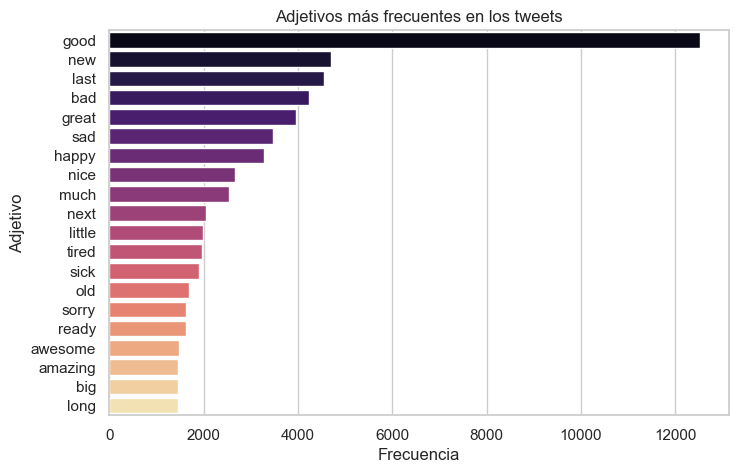

,Adjetivo,Frecuencia
0,good,12518
1,new,4692
2,last,4549
3,bad,4230
4,great,3960
5,sad,3467
6,happy,3282
7,nice,2665
8,much,2534
9,next,2048


In [18]:
#Tomamos una muestra del corpus para análisis sintáctico
sample_texts = df['clean_text'].tolist()

#Analizamos con spaCy
docs = list(nlp.pipe(sample_texts, disable=['ner']))

#1️.Distribución de etiquetas gramaticales (POS)
pos_counts = Counter([token.pos_ for doc in docs for token in doc])
pos_df = pd.DataFrame(pos_counts.most_common(), columns=['POS', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=pos_df, y='POS', x='Frecuencia', palette='crest')
plt.title("Distribución de categorías gramaticales (POS)")
plt.xlabel("Frecuencia")
plt.ylabel("Categoría")
plt.show()

#2️.Adjetivos más frecuentes (indicadores de opinión)
adj_counts = Counter([token.lemma_ for doc in docs for token in doc if token.pos_ == 'ADJ'])
adj_df = pd.DataFrame(adj_counts.most_common(20), columns=['Adjetivo', 'Frecuencia'])

plt.figure(figsize=(8,5))
sns.barplot(data=adj_df, y='Adjetivo', x='Frecuencia', palette='magma')
plt.title("Adjetivos más frecuentes en los tweets")
plt.xlabel("Frecuencia")
plt.ylabel("Adjetivo")
plt.show()

display(adj_df.head(10))


## Configuración, léxicos y utilidades

In [19]:
PALABRAS_POSITIVAS = {
    'good','great','awesome','excellent','amazing','wonderful','fantastic',
    'love','loved','loving','best','better','perfect','nice','beautiful',
    'happy','glad','joy','joyful','pleased','delighted','enjoy','enjoyed',
    'like','liked','favorite','brilliant','outstanding','superb','impressive',
    'positive','success','successful','win','winner','winning','recommend',
    'fun','interesting','cool','sweet','thanks','thank','appreciate',
    'worthy','worth','quality','helpful','easy','comfortable','pretty',
    'gorgeous','adorable','cute','charm','charming','pleasant','satisfied','awesome'
}

PALABRAS_NEGATIVAS = {
    'bad','terrible','awful','horrible','worst','worse','poor','hate',
    'hated','dislike','disappointing','disappointed','disappointment',
    'sad','angry','upset','annoying','annoyed','frustrating','frustrated',
    'boring','bored','dull','useless','waste','wasted','fail','failed',
    'failure','problem','issue','trouble','difficult','hard','sucks',
    'stupid','dumb','ugly','disgusting','nasty','gross','crap','shit',
    'damn','hell','wrong','error','broken','broke','uncomfortable',
    'painful','pain','suffer','suffering','regret','sorry','weak','scam','buggy'
}

NEGACIONES = {
    'not','no',"n't",'never','neither','nobody','nothing','nowhere',
    'none','nor','cannot','cant',"can't","won't","wouldn't","shouldn't",
    "couldn't","doesn't","don't","didn't","isn't","aren't","wasn't","weren't"
}

INTENSIFICADORES = {
    'very':1.5,'really':1.5,'extremely':2.0,'absolutely':1.8,
    'incredibly':1.8,'highly':1.5,'particularly':1.3,'especially':1.3,
    'totally':1.6,'completely':1.6,'utterly':1.7,'quite':1.2,
    'so':1.4,'too':1.3,'super':1.5,'exceptionally':1.8
}

ATENUADORES = {
    'somewhat':0.5,'slightly':0.5,'barely':0.4,'hardly':0.4,
    'almost':0.6,'nearly':0.6,'kind':0.5,'sort':0.5,
    'little':0.6,'bit':0.6,'rather':0.7,'fairly':0.7
}

#Emoticonos (NO emojis). Contribuyen como pequeño boost de polaridad.
EMOTICON_SENT = {
    ":)": 0.6, ":-)": 0.6, ":D": 0.9, ":-D": 0.9, ";)": 0.4,
    ":(": -0.6, ":-(": -0.6, ":'(": -0.9, ">:(": -1.1, "XD": 0.7
}

PIVOTES_CONTRASTE = {"but","however","though","although"}

@dataclass
class Config:
    usar_sentiwordnet: bool = True
    ventana_negacion: int = 3
    reset_negacion_en_puntuacion: bool = True
    boost_exclamacion: float = 0.10
    boost_repeticion: float = 0.10
    peso_pre_contraste: float = 0.5
    peso_post_contraste: float = 1.5
    max_stack_mod: int = 2
    limites_puntuacion_reset: set = field(default_factory=lambda: {".","!","?",";","—","-","…"})
    pos: set = field(default_factory=lambda: set(PALABRAS_POSITIVAS))
    neg: set = field(default_factory=lambda: set(PALABRAS_NEGATIVAS))
    negaciones: set = field(default_factory=lambda: set(NEGACIONES))
    intensificadores: dict = field(default_factory=lambda: dict(INTENSIFICADORES))
    atenuadores: dict = field(default_factory=lambda: dict(ATENUADORES))

CFG = Config()
print("Config preparada")


Config preparada


## Utilidades específicas de sentimiento (SentiWordNet, contadores)


In [20]:
def senti_from_swn(lemma: str, wn_pos) -> float:
    try:
        synsets = list(swn.senti_synsets(lemma, pos=wn_pos))
        if not synsets:
            return 0.0
        best = max(synsets, key=lambda ss: abs(ss.pos_score() - ss.neg_score()))
        return best.pos_score() - best.neg_score()
    except Exception:
        return 0.0

def contar_exclamaciones(texto: str) -> int:
    return texto.count('!')

def pos_tag_tokens(tokens):
    if not tokens:
        return []

    #Construimos un doc con los lemmas ya limpios
    doc = nlp(" ".join(tokens))

    #Recogemos solo tokens "reales" (sin espacios)
    spacy_pos = [t.pos_ for t in doc if not t.is_space]

    #Empareja longitudes por si spaCy tokeniza algo distinto
    L = min(len(tokens), len(spacy_pos))
    return [(tokens[i], spacy_pos[i]) for i in range(L)]


## Motor de análisis basado en reglas (mejorado)


In [21]:
PIVOTES_CONTRASTE = {"but","however","though","although"}

def _aplicar_modificador(score_word: float, modificador: float, negacion_activa: bool) -> float:
    v = score_word * modificador
    return -v if negacion_activa else v

def normalizar_emoticonos(texto: str) -> float:
    total = 0.0
    for emo, val in EMOTICON_SENT.items():
        total += texto.count(emo) * val
    return total

def _segmentos_contraste(tokens):
    for i, tok in enumerate(tokens):
        if tok in PIVOTES_CONTRASTE:
            return tokens[:i], tokens[i+1:]
    return tokens, []

def _to_wn_pos(tag: str):
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return wn.NOUN



REPEAT_CHAR_RE = re.compile(r'([a-zA-Z])\1{2,}')
def contar_repeticiones_letras(texto: str) -> int:
    return len(REPEAT_CHAR_RE.findall(texto))

def analizar_sentimiento_texto(texto: str, cfg: Config = CFG) -> float:

    if not texto:
        return 0.0

    #1.Boost por emoticonos en el texto ORIGINAL (no preprocesado)
    boost_emoticon = normalizar_emoticonos(texto)

    #2.Preprocesamiento NUEVO -> lemmas
    tokens = preprocess_review(texto, nlp, stop_words)
    if not tokens:
        return boost_emoticon

    #3.Segmentos de contraste
    left, right = _segmentos_contraste(tokens)

    def puntuar_bloque(btokens):
        score = 0.0
        if not btokens:
            return score

        #Etiquetado POS 
        tagged = pos_tag_tokens(btokens)

        negacion_activa = False
        ventana = 0
        stack_mod = 0
        modificador = 1.0

        for i, (tok, pos) in enumerate(tagged):
            #Reset por puntuación
            if cfg.reset_negacion_en_puntuacion and tok in cfg.limites_puntuacion_reset:
                negacion_activa = False
                ventana = 0
                modificador = 1.0
                stack_mod = 0
                continue

            #Ventana de negación
            if negacion_activa:
                ventana += 1
                if ventana > cfg.ventana_negacion:
                    negacion_activa = False
                    ventana = 0

            #Negaciones
            if tok in cfg.negaciones:
                negacion_activa = True
                ventana = 0
                continue

            #Intensificadores / Atenuadores
            if tok in cfg.intensificadores:
                modificador *= cfg.intensificadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = max(modificador, cfg.intensificadores[tok])
                continue

            if tok in cfg.atenuadores:
                modificador *= cfg.atenuadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = min(modificador, cfg.atenuadores[tok])
                continue

            #4.Puntuación por lexicón/SWN
            s = 0.0
            if tok in cfg.pos:
                s = 1.0
            elif tok in cfg.neg:
                s = -1.0
            elif cfg.usar_sentiwordnet:
                wn_pos = _to_wn_pos(pos)
                lemma = tok  #ya está lematizado por preprocess_review
                s = senti_from_swn(lemma, wn_pos)

            if s != 0.0:
                score += _aplicar_modificador(s, modificador, negacion_activa)
                modificador = 1.0
                stack_mod = 0

        return score

    score_left = puntuar_bloque(left)
    score_right = puntuar_bloque(right)
    score = (CFG.peso_pre_contraste * score_left + CFG.peso_post_contraste * score_right) if right else score_left

    #5.Paralingüísticos sobre el texto original
    excls = contar_exclamaciones(texto)
    reps = contar_repeticiones_letras(texto)
    if excls > 0:
        score *= (1 + CFG.boost_exclamacion * excls)
    if reps > 0:
        score *= (1 + CFG.boost_repeticion * reps)

    #6.Sumar boost de emoticonos
    score += boost_emoticon
    return score

#Pruebas rápidas
ejemplos = [
    "This is amazing! I love it! :)",
    "This is terrible. I hate it :(",
    "Not bad, quite good actually.",
    "This is not good at all.",
    "BEST MOVIE EVER!!!",
    "I wanted to like it, but it was boring...",
    "Great camera, however the battery is awful :(",
    "soooo goooood!!!",
    "I can't say it's bad",
]
for e in ejemplos:
    print(e, "->", round(analizar_sentimiento_texto(e), 3))



This is amazing! I love it! :) -> 3.0
This is terrible. I hate it :( -> -2.6
Not bad, quite good actually. -> 0.2
This is not good at all. -> 1.0
BEST MOVIE EVER!!! -> 1.3
I wanted to like it, but it was boring... -> -0.625
Great camera, however the battery is awful :( -> -1.975
soooo goooood!!! -> 0.0
I can't say it's bad -> -0.875


## VADER como referencia (silver labels) y utilidades


In [22]:
VADER = SentimentIntensityAnalyzer()

def vader_label(texto: str, pos_th=0.05, neg_th=-0.05):
    """Devuelve 4 (pos), 0 (neg) o None (neutral) según compound de VADER."""
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return None
    s = VADER.polarity_scores(str(texto))
    c = s["compound"]
    if c > pos_th: return 4
    if c < neg_th: return 0
    return None  # neutro

def vader_compound(texto: str):
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return 0.0
    return VADER.polarity_scores(str(texto))["compound"]

print("VADER listo")


VADER listo


## Calibración de umbral contra VADER (muestra, descartando neutros)


In [23]:
tam_muestra = min(20000, len(df))
sample = df.sample(n=tam_muestra, random_state=42).copy()

#Etiquetas VADER sobre el texto original (mejor para VADER)
tqdm.pandas(desc="VADER (muestra)")
sample["vader_label"] = sample['clean_text'].progress_apply(vader_label) #aplicamos VADER para obtener labels discretos 

#Filtrar a positvo y negativo para descartar tweets neutros
mask_eval = sample["vader_label"].isin([0,4])
valid = sample[mask_eval].copy()

if len(valid) < 100:
    mejor_umbral = 0.0
    print("Muy pocos casos positivos y negativos en la muestra. Umbral por defecto = 0.0")
else:
    tqdm.pandas(desc="Scoring muestra (reglas)")
    valid["score"] = valid["clean_text"].progress_apply(analizar_sentimiento_texto)

    #Búsqueda más fina de umbral
    umbrales = np.linspace(-2.0, 2.0, 81)
    def metricas_basicas(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = (y_true == y_pred).mean() if len(y_true) else 0.0
        neg_true = (y_true==0).sum()
        pos_true = (y_true==4).sum()
        neg_correct = ((y_true==0) & (y_pred==0)).sum()
        pos_correct = ((y_true==4) & (y_pred==4)).sum()
        recall_neg = (neg_correct/neg_true) if neg_true else 0.0
        recall_pos = (pos_correct/pos_true) if pos_true else 0.0
        bacc = 0.5*(recall_neg+recall_pos)
        return {"accuracy":float(acc),"balanced_accuracy":float(bacc),
                "recall_neg":float(recall_neg),"recall_pos":float(recall_pos)}

    mejor_umbral, metr_mejor = None, None
    y_true = valid["vader_label"].values
    scores = valid["score"].values
    for u in umbrales:
        y_pred = np.where(scores > u, 4, 0)
        m = metricas_basicas(y_true, y_pred)
        if (metr_mejor is None) or (m["balanced_accuracy"] > metr_mejor["balanced_accuracy"]):
            mejor_umbral, metr_mejor = u, m

    print("Calibración vs VADER completada")
    print(f"Mejor umbral: {mejor_umbral:.3f}")
    print("Métricas (muestra vs VADER):", metr_mejor)


VADER (muestra):   0%|          | 0/20000 [00:00<?, ?it/s]

Scoring muestra (reglas):   0%|          | 0/14722 [00:00<?, ?it/s]

Calibración vs VADER completada
Mejor umbral: 0.300
Métricas (muestra vs VADER): {'accuracy': 0.7316940633066159, 'balanced_accuracy': 0.7403728700310837, 'recall_neg': 0.7650387759379585, 'recall_pos': 0.7157069641242086}


## Scoring/predicción en todo el dataset + VADER para evaluación


In [24]:
tqdm.pandas(desc="Scoring dataset (reglas)")

df["sentiment_score"] = df["clean_text"].progress_apply(analizar_sentimiento_texto)
df["sentiment_pred"] = (df["sentiment_score"] > mejor_umbral).astype(int).replace({0:0,1:4})

#VADER sobre todo el dataset (texto original)
tqdm.pandas(desc="VADER (completo)")
df["vader_label"] = df['clean_text'].progress_apply(vader_label)
df["vader_compound"] = df['clean_text'].progress_apply(vader_compound)

print("Distribución de predicciones (reglas):")
print(df["sentiment_pred"].value_counts())
print(df["sentiment_pred"].value_counts(normalize=True))
print("\nDistribución VADER (silver):")
print(df["vader_label"].value_counts(dropna=False))


Scoring dataset (reglas):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

Distribución de predicciones (reglas):
sentiment_pred
4    101376
0     98624
Name: count, dtype: int64
sentiment_pred
4    0.50688
0    0.49312
Name: proportion, dtype: float64

Distribución VADER (silver):
vader_label
4.0    99077
NaN    53440
0.0    47483
Name: count, dtype: int64


## Matriz de confusión (Nuestro modelo vs VADER) — neutros descartados


Conteos (absolutos):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),36519,10964
Real POS (VADER=4),28255,70822



Porcentajes por FILA (≈ recall por clase VADER):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),76.91,23.09
Real POS (VADER=4),28.52,71.48



Porcentajes por COLUMNA (≈ precision de nuestro modelo):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),56.38,13.41
Real POS (VADER=4),43.62,86.59



Porcentajes sobre el TOTAL:


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),24.92,7.48
Real POS (VADER=4),19.28,48.32


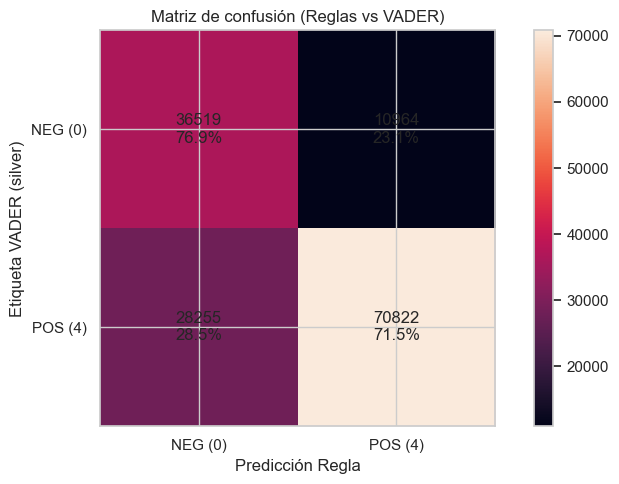

In [25]:
mask = df["vader_label"].isin([0,4]) & df["sentiment_pred"].isin([0,4])
if mask.sum() == 0:
    print("No hay datos suficientes (VADER positivos/neggativos) para matriz de confusión.")
else:
    y_true = (df.loc[mask, "vader_label"] == 4).astype(int).values  # 0/1
    y_pred = (df.loc[mask, "sentiment_pred"] == 4).astype(int).values

    TN = int(((y_true==0) & (y_pred==0)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())
    TP = int(((y_true==1) & (y_pred==1)).sum())
    cm = np.array([[TN, FP],[FN, TP]], dtype=int)

    df_counts = pd.DataFrame(
        cm, index=["Real NEG (VADER=0)","Real POS (VADER=4)"],
        columns=["Pred NEG (Reglas=0)","Pred POS (Reglas=4)"]
    )
    row_sums = df_counts.sum(axis=1).replace(0, np.nan)
    col_sums = df_counts.sum(axis=0).replace(0, np.nan)
    total = df_counts.values.sum()

    df_row_pct = (df_counts.div(row_sums, axis=0) * 100).round(2)
    df_col_pct = (df_counts.div(col_sums, axis=1) * 100).round(2)
    df_all_pct = (df_counts / total * 100).round(2) if total>0 else df_counts.astype(float)

    print("Conteos (absolutos):")
    display(df_counts)
    print("\nPorcentajes por FILA (≈ recall por clase VADER):")
    display(df_row_pct)
    print("\nPorcentajes por COLUMNA (≈ precision de nuestro modelo):")
    display(df_col_pct)
    print("\nPorcentajes sobre el TOTAL:")
    display(df_all_pct)

    #Heatmap simple con anotaciones (conteo + % por fila)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión (Reglas vs VADER)")
    plt.xlabel("Predicción Regla")
    plt.ylabel("Etiqueta VADER (silver)")
    plt.xticks([0,1], ["NEG (0)","POS (4)"])
    plt.yticks([0,1], ["NEG (0)","POS (4)"])

    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            fila = cm[i, :].sum()
            pct_row = (val / fila * 100) if fila > 0 else 0.0
            plt.text(j, i, f"{val}\n{pct_row:.1f}%", ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()


## Gráfico de distribución de scores


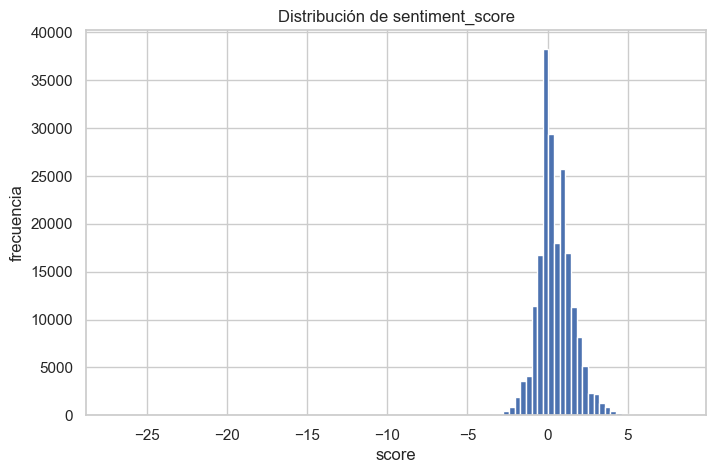

In [26]:
plt.figure()
df["sentiment_score"].hist(bins=100)
plt.title("Distribución de sentiment_score")
plt.xlabel("score")
plt.ylabel("frecuencia")
plt.show()


## Ejemplos donde el modelo se equivoca contra VADER (5 FP y 5 FN)


In [27]:
# - **FP**: VADER=0 (neg) y nuestro modelo=4 (pos)
# - **FN**: VADER=4 (pos) y nuestro modelo=0 (neg)
# Se priorizan los casos con mayor distancia al umbral.

if "sentiment_pred" not in df.columns or "sentiment_score" not in df.columns or "vader_label" not in df.columns:
    print("Faltan columnas. Ejecuta scoring y VADER antes.")
else:
    mask_fp = (df["vader_label"] == 0) & (df["sentiment_pred"] == 4)
    mask_fn = (df["vader_label"] == 4) & (df["sentiment_pred"] == 0)

    cols = ['clean_text', "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
    ejemplos_fp = df.loc[mask_fp, cols].copy()
    ejemplos_fn = df.loc[mask_fn, cols].copy()

    umbral = float(globals().get("mejor_umbral", 0.0))
    ejemplos_fp["dist_umbral"] = (ejemplos_fp["sentiment_score"] - umbral).abs()
    ejemplos_fn["dist_umbral"] = (ejemplos_fn["sentiment_score"] - umbral).abs()

    top_fp = ejemplos_fp.sort_values("dist_umbral", ascending=False).head(5)
    top_fn = ejemplos_fn.sort_values("dist_umbral", ascending=False).head(5)

    print("──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────")
    for _, row in top_fp.iterrows():
        txt = str(row['clean_text']).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: NEG | Pred(Reglas): POS ✗  | compound={row['vader_compound']:.3f}\n")

    print("──────────── FALSOS NEGATIVOS (VADER POS=4, Reglas NEG=0) ────────────")
    for _, row in top_fn.iterrows():
        txt = str(row['clean_text']).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: POS | Pred(Reglas): NEG ✗  | compound={row['vader_compound']:.3f}\n")

    print("Tabla 5: FALSOS POSITIVOS")
    display(top_fp.drop(columns=['dist_umbral']).reset_index(drop=True))

    print("Tabla 5: FALSOS NEGATIVOS")
    display(top_fn.drop(columns=['dist_umbral']).reset_index(drop=True))


──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────
Texto: finally buy box ciggie pack yea know kill maself slowly yea know know mom...
Score: 4.500 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.691

Texto: cool kill really pretty bird aion quest kill still dun like...
Score: 4.375 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.478

Texto: kill light amp amp take time baby call hollywood add amazing...
Score: 4.250 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.226

Texto: show fenway dirty water guy kill thank also love new music...
Score: 4.125 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.226

Texto: teach kid evil wonder grandma would still recommend education course know...
Score: 4.000 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.440

──────────── FALSOS NEGATIVOS (VADER POS=4, Reglas NEG=0) ────────────
Texto: ugh sit airpost super tired super bored want sleep still minute even load plane save...
Score: -4.750 | VADER: POS | Pred(Reglas): NE

,clean_text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,finally buy box ciggie pack yea know kill mase...,4.500,4,0.0,-0.6908
1,cool kill really pretty bird aion quest kill s...,4.375,4,0.0,-0.4779
2,kill light amp amp take time baby call hollywo...,4.250,4,0.0,-0.2263
3,show fenway dirty water guy kill thank also lo...,4.125,4,0.0,-0.2263
4,teach kid evil wonder grandma would still reco...,4.000,4,0.0,-0.4404


Tabla 5: FALSOS NEGATIVOS


,clean_text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,ugh sit airpost super tired super bored want s...,-4.750000,0,4.0,0.6705
1,really really really really really want see qu...,-3.996094,0,4.0,0.2812
2,ready cheer boot camp start hopefully kick ass...,-3.625000,0,4.0,0.5423
3,problem remove device save free space difficult,-3.500000,0,4.0,0.3182
4,really update twitter acc since week ago reall...,-3.375000,0,4.0,0.5617


## Exportación a CSV


In [28]:
#Exportamos las columnas útiles sin depender de `target`.
cols_export = ['text', "clean_text", "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
out_path = "resultados_sentimientos_v2_silver.csv"
df[cols_export].to_csv(out_path, index=False)
print(f"Resultados exportados a: {out_path} (total={len(df):,})")


Resultados exportados a: resultados_sentimientos_v2_silver.csv (total=200,000)


## Dashboard con métricas de sentimiento por categorías

C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\581343951.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_pred', palette='coolwarm')


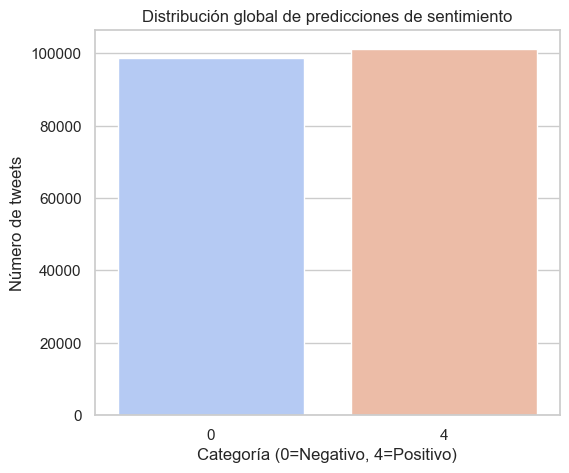

In [29]:
#Distribución general de sentimientos
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='sentiment_pred', palette='coolwarm')
plt.title("Distribución global de predicciones de sentimiento")
plt.xlabel("Categoría (0=Negativo, 4=Positivo)")
plt.ylabel("Número de tweets")
plt.show()


C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\640229703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x='sentiment_pred', y='mean_score', palette='Set2')


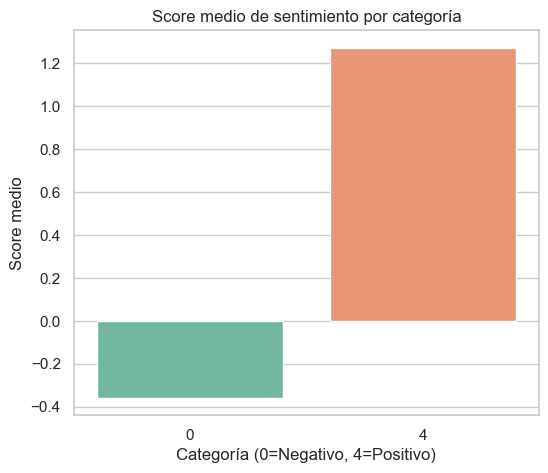

In [30]:
#Métricas promedio por categoría (score medio)
metrics = df.groupby('sentiment_pred').agg(
    mean_score=('sentiment_score','mean'),
    median_score=('sentiment_score','median'),
    count=('sentiment_score','count')
).reset_index()

plt.figure(figsize=(6,5))
sns.barplot(data=metrics, x='sentiment_pred', y='mean_score', palette='Set2')
plt.title("Score medio de sentimiento por categoría")
plt.xlabel("Categoría (0=Negativo, 4=Positivo)")
plt.ylabel("Score medio")
plt.show()


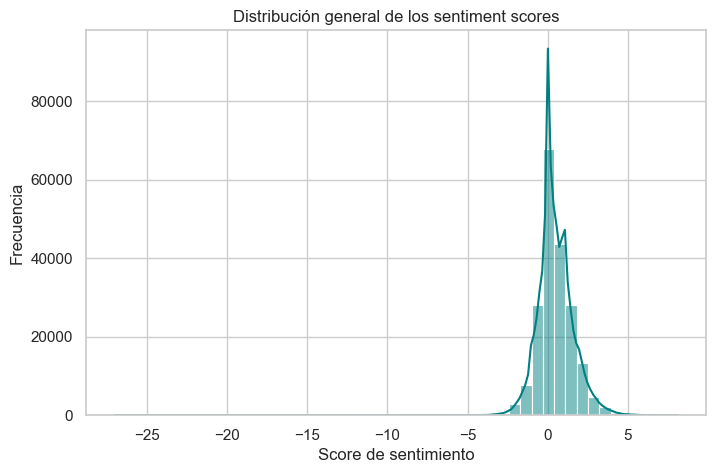

In [31]:
#Histograma de scores 
plt.figure(figsize=(8,5))
sns.histplot(df['sentiment_score'], bins=50, kde=True, color='teal')
plt.title("Distribución general de los sentiment scores")
plt.xlabel("Score de sentimiento")
plt.ylabel("Frecuencia")
plt.show()


In [32]:
#tweets más positivos y negativos
print("Ejemplos más positivos:")
display(df.nlargest(5, 'sentiment_score')[['clean_text','sentiment_score']])

print("\n Ejemplos más negativos:")
display(df.nsmallest(5, 'sentiment_score')[['clean_text','sentiment_score']])


Ejemplos más positivos:


,clean_text,sentiment_score
191412,gorgeous day super happy today really excited ...,8.1250
89538,ahhhhhh love stacey love stacey love stacey lo...,7.7000
37694,sweet haha like super proud new mom feel like ...,7.5625
30700,thank love appreciate love friend see everyday...,7.0000
100409,good luck giirl nit mtv movie award fun brandi...,6.8750



 Ejemplos más negativos:


,clean_text,sentiment_score
141572,shit shit shit shit shit shit shit shit shit s...,-27.0000
3160,hate exam hate exam hate exam hate exam hate e...,-11.0000
48119,hate hate hate hate hate hate hate hateeeeeeee...,-7.5625
24267,really bored pain killer still havnt kick stop...,-6.8750
131535,hate hate hate hate hate hate norwegian exam t...,-6.6250


## Análisis de palabras más influyentes

In [33]:
from collections import defaultdict

#Creamos un diccionario para acumular score por palabra
word_scores = defaultdict(list)

for lemmas, score in zip(df['lemmas'], df['sentiment_score']):
    for w in lemmas:
        word_scores[w].append(score)

#Calculamos el score promedio y número de apariciones
word_stats = [(w, np.mean(scores), len(scores)) for w, scores in word_scores.items()]
word_stats_df = pd.DataFrame(word_stats, columns=['word', 'mean_score', 'count'])


In [34]:
#Filtramos las palabras con suficiente frecuencia
min_count = 50  #ponemos un mínimo de apariciones para considerar
word_stats_df = word_stats_df[word_stats_df['count'] >= min_count]


In [35]:
#Extraemos las palabras más positivas y negativas
top_pos_words = word_stats_df.sort_values('mean_score', ascending=False).head(20)
top_neg_words = word_stats_df.sort_values('mean_score').head(20)


C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\3039816735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos_words, y='word', x='mean_score', palette='Greens_r')


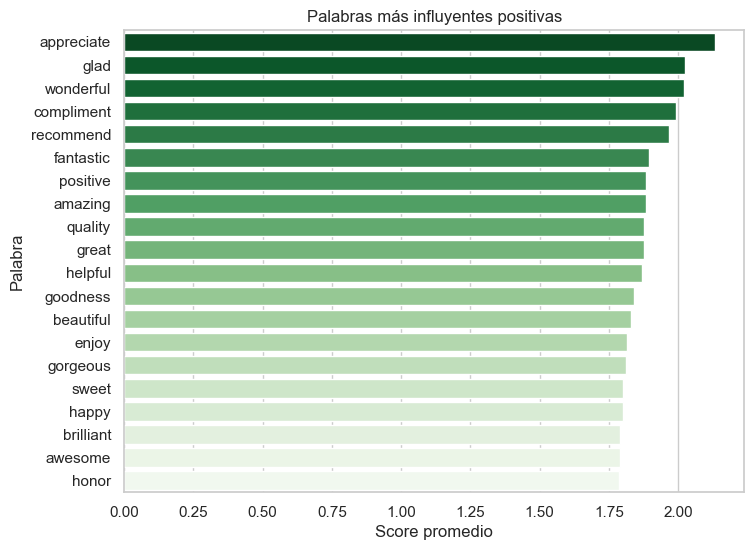

C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\3039816735.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg_words, y='word', x='mean_score', palette='Reds_r')


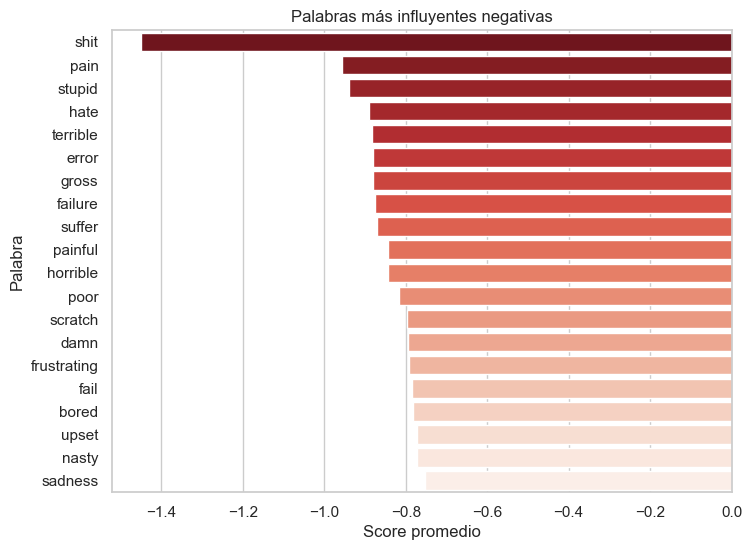

In [36]:
#Mostramos las palabras positivas y negativas más influyentes 
plt.figure(figsize=(8,6))
sns.barplot(data=top_pos_words, y='word', x='mean_score', palette='Greens_r')
plt.title("Palabras más influyentes positivas")
plt.xlabel("Score promedio")
plt.ylabel("Palabra")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(data=top_neg_words, y='word', x='mean_score', palette='Reds_r')
plt.title("Palabras más influyentes negativas")
plt.xlabel("Score promedio")
plt.ylabel("Palabra")
plt.show()


## Comparación de métodos implementados

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
# Seleccionamos solo filas con etiqueta VADER conocida
mask_eval = df["vader_label"].isin([0,4])
eval_df = df[mask_eval].copy()


In [39]:
#Nos aseguramos de tener las etiquetas binarias
y_true = (eval_df['vader_label'] == 4).astype(int)  
y_pred = (eval_df['sentiment_pred'] == 4).astype(int)  

In [40]:
#Metricas
print("\n📊 Clasification Report (Reglas vs VADER):")
print(classification_report(y_true, y_pred, target_names=['NEG','POS']))


📊 Clasification Report (Reglas vs VADER):
              precision    recall  f1-score   support

         NEG       0.56      0.77      0.65     47483
         POS       0.87      0.71      0.78     99077

    accuracy                           0.73    146560
   macro avg       0.71      0.74      0.72    146560
weighted avg       0.77      0.73      0.74    146560



C:\Users\wail-\AppData\Local\Temp\ipykernel_4296\3243550195.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(means.keys()), y=list(means.values()), palette='coolwarm')


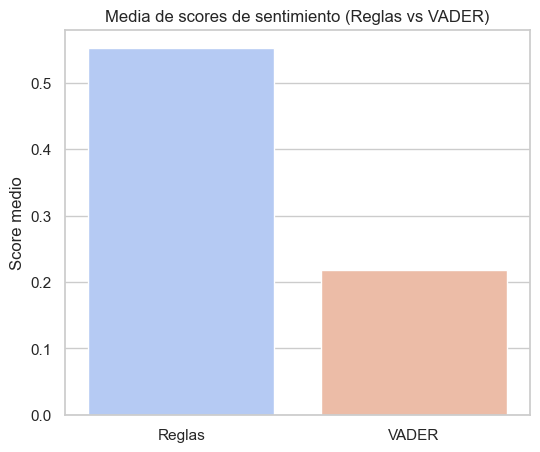

In [41]:
#Comparación de medias de scores
means = {
    'Reglas': eval_df['sentiment_score'].mean(),
    'VADER': eval_df['vader_compound'].mean()
}

plt.figure(figsize=(6,5))
sns.barplot(x=list(means.keys()), y=list(means.values()), palette='coolwarm')
plt.title("Media de scores de sentimiento (Reglas vs VADER)")
plt.ylabel("Score medio")
plt.show()


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   text             200000 non-null  object 
 1   lemmas           200000 non-null  object 
 2   clean_text       200000 non-null  object 
 3   sentiment_score  200000 non-null  float64
 4   sentiment_pred   200000 non-null  int64  
 5   vader_label      146560 non-null  float64
 6   vader_compound   200000 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ MB
